# Exercise 7 - Image Formation

In [1]:
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
import numpy as np
from copy import deepcopy

from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.utils.signals import tone_burst
from kwave.kWaveSimulation import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions

# Definitions: 

class Source:
    def __init__(self,
        f0: float, amplitude: float, cyclesPerPulse: int,
        totalApertureSize: float, txApertureSize: float, rxApertureSize: float,
        position: tuple[float, float]
    ):
        self.f0 = f0
        self.amplitude = amplitude
        self.cyclesPerPulse = cyclesPerPulse
        self.totalApertureSize = totalApertureSize
        self.txApertureSize = txApertureSize
        self.rxApertureSize = rxApertureSize
        self.position = position
    
    def getPulse(self, dt, delays=0):
        return self.amplitude * tone_burst(1 / dt, self.f0, self.cyclesPerPulse, signal_offset=delays)

class Target:
    def __init__(self, position: tuple[float, float], steerAngle: float):
        self.position = position
        self.txFocusDepth = position[0]
        self.rxFocusDepth = position[0]
        self.steerAngle = steerAngle
    
    def setTxFocusDepth(self, depth: float):
        self.txFocusDepth = depth
    
    def setRxFocusDepth(self, depth: float):
        self.rxFocusDepth = depth

class Grid:
    def __init__(self, gridSize: tuple, dx: float):
        self.gridSize = gridSize
        self.dx = dx
        self.Nx = np.round(gridSize[0]/dx).astype(int)
        self.Ny = np.round(gridSize[1]/dx).astype(int)
        self.Ny += int(self.Ny % 2 == 0)    # Force odd number of lateral points
        self.dy = gridSize[1] / self.Ny
        self.kgrid = kWaveGrid([self.Nx, self.Ny], [self.dx, self.dy])
    
    def generateTimeArray(self, c0, cfl):
        t_end = 2 * self.gridSize[0] / c0
        self.kgrid.makeTime(c0, cfl, t_end)

class Aperture:
    def __init__(self, totalSize: float, txSize: float, rxSize: float, dx: float):
        self.totalSize = totalSize
        self.txSize = txSize
        self.rxSize = rxSize
        self.Ntx = round(txSize/dx)
        self.Ntx += int(self.Ntx % 2 == 0)
        self.Nrx = round(rxSize/dx)
        self.Nrx += int(self.Nrx % 2 == 0)
        self.N = round(totalSize/dx)
        self.N += int(self.N % 2 == 0)

# Configuration:

source = Source(
 f0=1e6,
 amplitude=1e6,
 cyclesPerPulse=2,
 totalApertureSize=3e-2,
 txApertureSize=1e-2,
 rxApertureSize=1e-2,
 position=[-40e-3, 0],
)

target = Target(
 position=[0.02, 0],
 steerAngle=0#*np.pi/180
)

c0 = 1540
ppw = 10
cfl = 0.1

grid = Grid(
 gridSize=(40e-3, 40e-3),
 dx=c0/(ppw*source.f0)
)
grid.generateTimeArray(c0, cfl)

aperture = Aperture(
 totalSize=0.03,
 txSize=0.01,
 rxSize=0.01,
 dx=grid.dx
)

sourceIndex = np.maximum(0, np.round((source.position[0] - grid.kgrid.x_vec[0]) / grid.kgrid.dx).astype(int)[0])

zAxis = grid.kgrid.x_vec - grid.kgrid.x_vec[0]
xAxis = grid.kgrid.y_vec

# extent = np.array([zAxis[0], zAxis[-1], xAxis[0], xAxis[-1]])*1e3

rho0 = 1000
medium = kWaveMedium(sound_speed=c0, density=rho0)
medium.sound_speed = np.ones_like(grid.kgrid.x) * c0
medium.density = np.ones_like(grid.kgrid.x) * rho0

# Add scatterers to medium
pointTargets = np.array([0.01, 0.02, 0.03])
pointTargetIndices = [np.argmin(np.abs(zAxis - pointTarget)) for pointTarget in pointTargets]

# medium.sound_speed[pointTargetIndices, int(grid.Ny/2)] = c0
medium.density[pointTargetIndices, int(grid.Ny/2)] = 4000

sensor = kSensor(record=['p', 'p_max'])
sensor.mask = np.zeros_like(grid.kgrid.x)


In [2]:
# Helpers:

def getDelayProfile(sourcePositions: tuple[np.ndarray, np.ndarray], focusPoint: tuple[float, float], angle: float):
    x = sourcePositions[0]
    y = sourcePositions[1]

    dxFp = x - focusPoint[0]
    dyFp = y - focusPoint[1]
    distanceFp = np.sqrt(dxFp**2 + dyFp**2)

    dxCenter = x[len(x)//2] - focusPoint[0]
    dyCenter = y[len(y)//2] - focusPoint[1]
    distanceCenter = np.sqrt(dxCenter**2 + dyCenter**2)

    delayProfile = (distanceCenter - distanceFp) / c0
    delayProfile -= np.min(delayProfile)

    delayProfile += np.tan(angle) * y / c0

    return delayProfile

def getSignalOffsets(sourcePositions: tuple[np.ndarray, np.ndarray], focusPoint: tuple[float, float], angle: float, dt: float):
    delayProfile = getDelayProfile(sourcePositions, focusPoint, angle)
    return np.round(delayProfile / dt).astype(int)

def simulateSingleLine(source, grid, medium, sensor, inputFilename="input_data.h5", outputFilename="output_data.h5"):
    return kspaceFirstOrder2D(
        kgrid=deepcopy(grid.kgrid),
        medium=deepcopy(medium),
        source=deepcopy(source),
        sensor=deepcopy(sensor),
        simulation_options=SimulationOptions(
            pml_auto=True,
            pml_inside=False,
            save_to_disk=True,
            input_filename=inputFilename,
            output_filename=outputFilename,
            data_cast="single",
        ),
        execution_options=SimulationExecutionOptions(
            is_gpu_simulation=False,
            show_sim_log=False
        )
    )

In [3]:
from IPython.display import clear_output
from tqdm import tqdm
%matplotlib inline

plotDelayProfile = False

stepSize = 1
apertureStartIndices = np.arange(0, aperture.N-aperture.Ntx+1, stepSize)

transducerIndices = np.round((np.arange(grid.Ny/2 - aperture.N/2, grid.Ny/2 + aperture.N/2, 1))).astype(int)

extent = np.array([zAxis[0], zAxis[-1], xAxis[-1], xAxis[0]])*1e3

sensor.mask[sourceIndex, transducerIndices] = 1

def apertureSim(i):
    ap = apertureStartIndices[i]
    sourceAperture = np.round((np.arange(grid.Ny/2 - aperture.N/2 + ap, grid.Ny/2 - aperture.N/2 + aperture.Ntx + ap, 1))).astype(int)
    ksource = kSource()
    ksource.p_mask = np.zeros_like(grid.kgrid.x)
    ksource.p_mask[sourceIndex, sourceAperture] = 1

    sourceY = grid.kgrid.y_vec[sourceAperture]
    sourceX = np.zeros_like(sourceY)

    # Transmit beamforming:
    focalPoint = np.array([target.txFocusDepth, sourceY[round(len(sourceY)/2)][0]])
    signalOffsets = getSignalOffsets([sourceX, sourceY], focalPoint, target.steerAngle, grid.kgrid.dt)

    if plotDelayProfile:
        clear_output(wait=True)
        fig = plt.figure(figsize=(10, 4))
        plt.grid()
        # plt.plot(sourceY*1e3, delayProfile*1e6)
        plt.plot(sourceY*1e3, signalOffsets*grid.kgrid.dt*1e6, 'ro')
        plt.show()

    pulse = source.getPulse(dt=grid.kgrid.dt, delays=signalOffsets)
    ksource.p = pulse

    lineData = simulateSingleLine(ksource, grid, medium, sensor, inputFilename=f"input_data_{i}.h5", outputFilename=f"output_data_{i}.h5")
    pressureField = np.reshape(lineData["p"], (grid.kgrid.Nt, aperture.N), order="F")

    sensorAperture = pressureField[:, sourceAperture - transducerIndices[0]]
    
    # Receive beamforming:
    focalPointRx = np.array([target.rxFocusDepth, sourceY[round(len(sourceY)/2)][0]])
    signalOffsetsRx = getSignalOffsets([sourceX, sourceY], focalPointRx, target.steerAngle, grid.kgrid.dt)
    delayRx = np.max(signalOffsetsRx) - signalOffsetsRx

    for j in range(len(sourceY)):
        d = delayRx[j][0]
        sensorAperture[:,j] = np.roll(sensorAperture[:,j], -d)
        sensorAperture[-d::,j] = 0 # Set wrapped values to zero

    signalSum = np.sum(sensorAperture, axis=1)
    return signalSum

multiThreaded = False
if multiThreaded:
    # Turns out kwave is highly dependent on disk I/O speed, so there is no speedup from multithreading :(
    import multiprocessing as mp
    # with mp.Pool(mp.cpu_count()) as pool:
    with mp.Pool(4) as pool:
        results = pool.map(apertureSim, range(len((apertureStartIndices))))
    channelData = np.vstack(results).T
else:
    channelData = np.zeros((grid.kgrid.Nt, len(apertureStartIndices)))
    for i, ap in enumerate(tqdm(apertureStartIndices)):
        channelData[:,i] = apertureSim(i)


  0%|          | 0/131 [00:00<?, ?it/s]

100%|██████████| 131/131 [34:40<00:00, 15.88s/it]


In [ ]:
saveData = False
saveMetaData = False
loadData = False

# fileNameSuffix = "rough"
fileNameSuffix = "detailed"

if saveData:
    np.save(f"../output/7/channelData_{fileNameSuffix}.npy", {
        "channelData": channelData,
    })

if saveMetaData:
    np.save(f"../output/7/metaData.npy", {
        "apertureStartIndices": apertureStartIndices,
        "aperture": aperture,
        "grid": grid,
        "medium": medium,
        "sensor": sensor,
        "target": target,
        "source": source,
        "zAxis": zAxis,
        "xAxis": xAxis,
        "c0": c0,
        "ppw": ppw,
        "cfl": cfl,
        "fileNameSuffix": fileNameSuffix,
        "targets": target,
        "pointTargets": pointTargets,
        "pointTargetIndices": pointTargetIndices,
    })

if loadData:
    data = np.load(f"../output/7/metaData.npy", allow_pickle=True).item()
    channelData = data["channelData"]
    apertureStartIndices = data["apertureStartIndices"]
    aperture = data["aperture"]
    grid = data["grid"]
    medium = data["medium"]
    sensor = data["sensor"]
    target = data["target"]
    source = data["source"]
    zAxis = data["zAxis"]
    xAxis = data["xAxis"]
    c0 = data["c0"]
    ppw = data["ppw"]
    cfl = data["cfl"]
    fileNameSuffix = data["fileNameSuffix"]
    targets = data["targets"]
    pointTargets = data["pointTargets"]
    pointTargetIndices = data["pointTargetIndices"]

In [ ]:
# PSF

def getPSFMask(envelopeLog, peakPosition, dBThreshold=-6):
    x, z = peakPosition
    peakValue = envelopeLog[x, z]
    thresholdValue = peakValue + dBThreshold
    return envelopeLog >= thresholdValue

def getPSFWidths(PSFMask,xAxis, zAxis):
    indices = np.argwhere(PSFMask)
    if len(indices) == 0:
        return None
    xMin, zMin = indices.min(axis=0)
    xMax, zMax = indices.max(axis=0)
    bounds = np.array([xAxis[xMin], xAxis[xMax], zAxis[zMin], zAxis[zMax]])
    lateralWidth = xAxis[xMax] - xAxis[xMin]
    axialWidth = zAxis[zMax] - zAxis[zMin]
    return bounds, lateralWidth, axialWidth

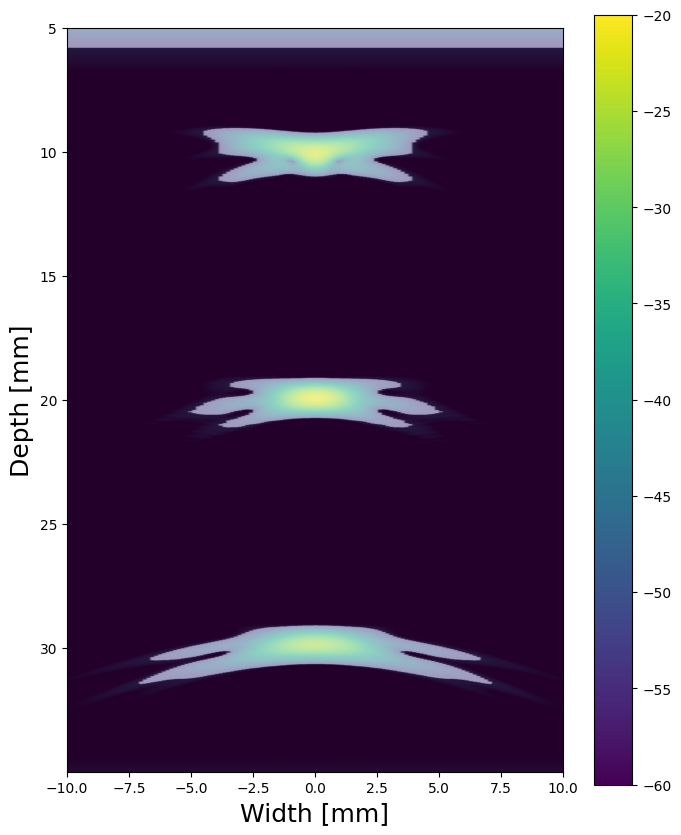

In [36]:
from scipy.signal import hilbert

highlightPSF = True

envelopeLog = 10 * np.log10(abs(hilbert(channelData, axis=0))**2 + np.finfo(float).eps)
envelopeLog -= np.max(envelopeLog)

channelXAxis = np.linspace((aperture.rxSize - aperture.totalSize)/2, (aperture.totalSize - aperture.rxSize)/2, aperture.Nrx)
pulseLength = c0 / source.f0 * source.cyclesPerPulse * 0.76
channelZAxis = (c0 * grid.kgrid.t_array - pulseLength)/2
channelZAxis = channelZAxis[0]

plt.figure(figsize=(8, 10))
plt.imshow(envelopeLog, aspect="auto", extent=np.array([channelXAxis[0], channelXAxis[-1], channelZAxis[-1], channelZAxis[0]])*1e3, vmin=-60, vmax=-20)
plt.colorbar()
plt.xlabel("Width [mm]", fontsize=18)
plt.ylabel("Depth [mm]", fontsize=18)

if highlightPSF:
    # Slice off start of envelope to avoid transmit pulse when finding peak (5mm on Z-axis)
    startDepth = 5e-3
    endDepth = 35e-3
    startDepthIndex = np.argmin(np.abs(channelZAxis - startDepth))
    endDepthIndex = np.argmin(np.abs(channelZAxis - endDepth))
    slicedEnvelopeLog = envelopeLog[startDepthIndex:endDepthIndex]
    peakPosition = np.unravel_index(np.argmax(slicedEnvelopeLog[:,0]), slicedEnvelopeLog.shape)
    PSFMask = getPSFMask(slicedEnvelopeLog, peakPosition, dBThreshold=-6)
    # Plot PSF
    plt.imshow(PSFMask, alpha=0.5, extent=np.array([channelXAxis[0], channelXAxis[-1], channelZAxis[endDepthIndex], channelZAxis[startDepthIndex]])*1e3, cmap="gray")

plt.show()

## Observations

I added a function which highlights the region around a peak that is above a threshold relative to the value of the peak to get a feel for the PSF.
With a threshold of -6dB, the highlighted area should show the spread out response from the point scatterers so we can see the width of the PSF.

Looking at the image we see the point spread width for the first scatterer is ~6mm, for the second it's ~10mm and for the third it's ~14mm.
In other words the point spread increases with depth. This is not really surprising as we are using fixed focal depth and aperture size, meaning the scatterers at depths other than the focus depth are not in focus.